In [ ]:
!pip install scikit-learn numpy pandas scipy matplotlib joblib

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import matplotlib.pyplot as plt
import joblib


In [ ]:
class WeatherModel:
    def __init__(self, file_path):
        self.file_path = file_path
        self.model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.label_encoders = {}
        self.best_params = None
        self.best_score = None
        self.cv_results = None

    def load_and_preprocess_data(self):
        df = pd.read_csv(self.file_path)
        df = df.dropna()

        for column in df.select_dtypes(include=['object']).columns:
            self.label_encoders[column] = LabelEncoder()
            df.loc[:, column] = self.label_encoders[column].fit_transform(df[column])

        X = df.drop('RainTomorrow', axis=1)
        y = df['RainTomorrow'].astype(int)

        #Hold-out com 30% para teste e 70% para treino
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle = True, stratify = y)

    def train_model(self):
        rfc = RandomForestClassifier()
        gbc = GradientBoostingClassifier()

        #Classificador ensemble com os 2 modelos
        ensemble_clf = VotingClassifier(estimators=[
            ('rfc', rfc),
            ('gbc', gbc),
        ], voting='soft')

        #Lista de parametros do gridsearch, RandomForest e Gradient boosting classifier
        param_grid = {
            'rfc__n_estimators': [100,200,300],
            'gbc__n_estimators': [100,200,300],
            'gbc__learning_rate': [0.5,0.1,0.01],
        }

        #GridSearch com 10 fold
        grid_search = GridSearchCV(estimator=ensemble_clf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2, error_score='raise')
        grid_search.fit(self.X_train, self.y_train)
        #Mostrando os resultados da busca
        print(grid_search.cv_results_)
        #Selecionando o Melhor modelo do gridsearch
        self.model = grid_search.best_estimator_

        # Coletar os melhores parâmetros e a melhor pontuação
        self.best_params = grid_search.best_params_
        self.best_score = grid_search.best_score_
        self.cv_results = grid_search.cv_results_

    def save_model(self, filename='best_ensemble_model.pkl'):
        joblib.dump(self.model, filename)

    def load_model(self, filename='best_ensemble_model.pkl'):
        self.model = joblib.load(filename)

    def evaluate_model(self):
        # Acurácia no conjunto de treino
        y_train_pred = self.model.predict(self.X_train)
        train_accuracy = accuracy_score(self.y_train, y_train_pred)
        print(f"Train Accuracy: {train_accuracy:.4f}")

        # Acurácia no conjunto de teste
        y_test_pred = self.model.predict(self.X_test)
        test_accuracy = accuracy_score(self.y_test, y_test_pred)
        print(f"Test Accuracy: {test_accuracy:.4f}")

        print("Classification Report (Test Set):\n", classification_report(self.y_test, y_test_pred))
        print("Confusion Matrix (Test Set):\n", confusion_matrix(self.y_test, y_test_pred))

        print("Classification Report (Train Set):\n", classification_report(self.y_train, y_train_pred))
        print("Confusion Matrix (Train Set):\n", confusion_matrix(self.y_train, y_train_pred))

        # Avaliação de overfitting usando validação cruzada no conjunto de treino e teste
        train_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=10)
        test_scores = cross_val_score(self.model, self.X_test, self.y_test, cv=10)

        train_mean = np.mean(train_scores)
        test_mean = np.mean(test_scores)
        conf_interval = stats.norm.interval(0.95, loc=test_mean, scale=stats.sem(test_scores))

        print(f"Train Scores Mean: {train_mean:.4f}")
        print(f"Test Scores Mean: {test_mean:.4f}")
        print(f"95% Confidence Interval for Test Scores: ({conf_interval[0]:.4f}, {conf_interval[1]:.4f})")

    def get_best_params_and_results(self):
        print(f"Best Parameters: {self.best_params}")
        print(f"Best Cross-Validation Score: {self.best_score:.4f}")
        print("CV Results:")
        for mean_score, params in zip(self.cv_results['mean_test_score'], self.cv_results['params']):
            print(f"{mean_score:.4f} with: {params}")

    def plot_learning_curve(self):
        def plot_learning_curve(estimator, title, X, y, cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
            plt.figure()
            plt.title(title)
            plt.xlabel("Training examples")
            plt.ylabel("Score")

            train_sizes, train_scores, test_scores = learning_curve(
                estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')

            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)

            plt.grid()

            plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                             color="r")
            plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
            plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
            plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")

            plt.legend(loc="best")
            return plt

        plot_learning_curve(self.model, "Learning Curve (Best Model)", self.X_train, self.y_train, cv=10)
        plt.show()

    def plot_validation_curves(self):
        def plot_validation_curve(estimator, title, X, y, param_name, param_range, cv=10, n_jobs=-1):
            train_scores, test_scores = validation_curve(
                estimator, X, y, param_name=param_name, param_range=param_range,
                cv=cv, scoring='accuracy', n_jobs=n_jobs)

            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)

            plt.figure()
            plt.title(title)
            plt.xlabel(param_name)
            plt.ylabel("Score")
            plt.ylim(0.0, 1.1)
            plt.grid()

            plt.fill_between(param_range, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                             color="r")
            plt.fill_between(param_range, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
            plt.plot(param_range, train_scores_mean, 'o-', color="r",
                     label="Training score")
            plt.plot(param_range, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")

            plt.legend(loc="best")
            return plt

        plot_validation_curve(self.model.named_estimators_['rfc'], "Validation Curve (RandomForestClassifier, n_estimators)",
                              self.X_train, self.y_train, param_name='n_estimators', param_range=[100, 200, 300], cv=10)
        plt.show()

        plot_validation_curve(self.model.named_estimators_['gbc'], "Validation Curve (GradientBoostingClassifier, n_estimators)",
                              self.X_train, self.y_train, param_name='n_estimators', param_range=[100, 200, 300], cv=10)
        plt.show()

        plot_validation_curve(self.model.named_estimators_['gbc'], "Validation Curve (GradientBoostingClassifier, learning_rate)",
                              self.X_train, self.y_train, param_name='learning_rate', param_range=[0.01, 0.1, 0.5], cv=10)
        plt.show()

In [ ]:
weather_model = WeatherModel(file_path='/content/drive/MyDrive/2024_01/Aprendizado de Máquina/dataset/weatherAUS.csv' )
weather_model.load_and_preprocess_data()
weather_model.train_model()
weather_model.save_model()

Fitting 10 folds for each of 27 candidates, totalling 270 fits
{'mean_fit_time': array([28.33199315, 40.03051333, 51.73886271, 43.44426312, 55.03225992,
       67.04761541, 58.58266101, 70.81263561, 82.67007422, 27.60023921,
       39.65007265, 52.03485465, 43.24018118, 54.65998216, 66.80807798,
       58.00937846, 69.71452363, 82.46174126, 27.85086067, 39.56347017,
       51.22923689, 43.21443002, 54.9607959 , 66.48505409, 58.25856574,
       70.20742424, 82.20450377]), 'std_fit_time': array([0.40446119, 0.78020064, 0.87190889, 0.73057648, 1.03979962,
       1.26754922, 0.85438295, 1.28208662, 0.83216576, 0.93942455,
       0.76944814, 1.02898608, 0.88375355, 1.28734028, 1.01161715,
       0.47785238, 1.43554155, 1.10890313, 0.86938022, 1.13337354,
       0.52352288, 0.76689039, 0.92054163, 0.74500801, 0.61187194,
       1.16849254, 0.80195962]), 'mean_score_time': array([0.18597732, 0.32020071, 0.49679451, 0.17070823, 0.3288321 ,
       0.43900235, 0.18635473, 0.29602256, 0.54672987,

In [ ]:
#validação do modelo
weather_model.evaluate_model()

Train Accuracy: 0.9566
Test Accuracy: 0.8652
Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.89      0.95      0.92     13198
           1       0.75      0.58      0.65      3728

    accuracy                           0.87     16926
   macro avg       0.82      0.76      0.78     16926
weighted avg       0.86      0.87      0.86     16926

Confusion Matrix (Test Set):
 [[12501   697]
 [ 1584  2144]]
Classification Report (Train Set):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     30795
           1       0.97      0.83      0.89      8699

    accuracy                           0.96     39494
   macro avg       0.96      0.91      0.93     39494
weighted avg       0.96      0.96      0.96     39494

Confusion Matrix (Train Set):
 [[30549   246]
 [ 1469  7230]]
Train Scores Mean: 0.8660
Test Scores Mean: 0.8566
95% Confidence Interval for Test Scores: (0.8516, 0.8615

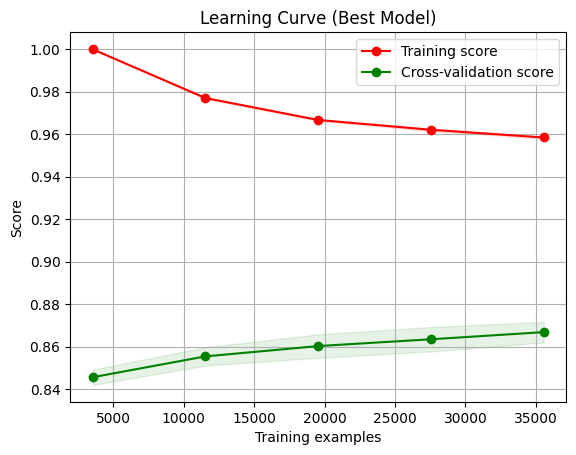

In [ ]:
weather_model.plot_learning_curve()

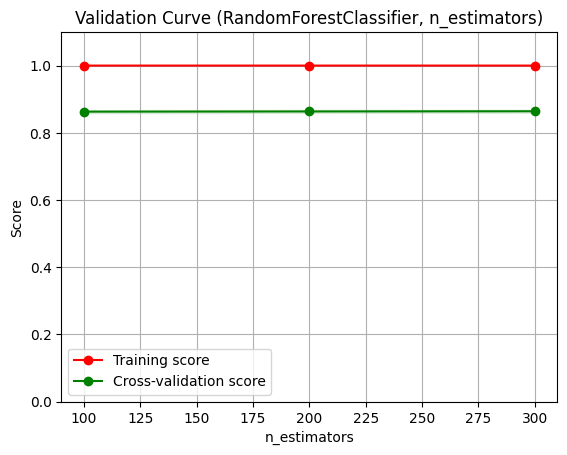

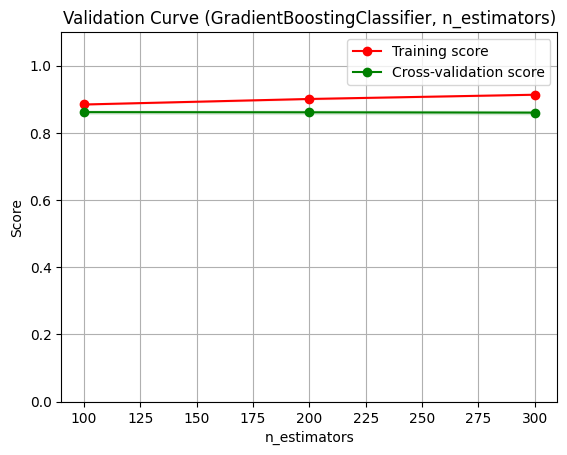

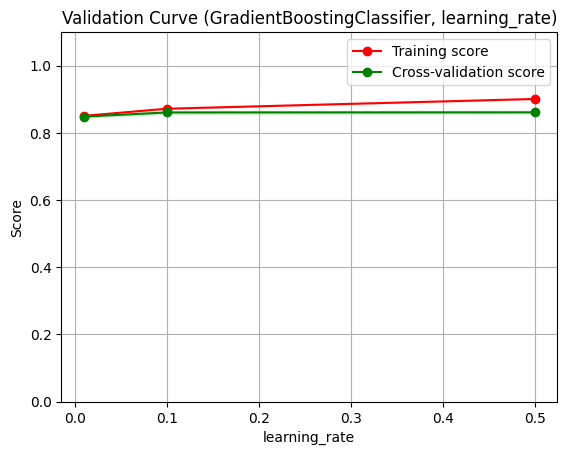

In [ ]:
weather_model.plot_validation_curves()